# Data science automation

This week is all about looking at automation tehcniques for data science and with Python. We can automate a lot of things with Python: collecting data, processing it, cleaning it, and many other parts of the data science pipeline. Here, we will show how to:

- use the pycaret autoML Python package to find an optimized ML model for our diabetes dataset
- create a Python script to ingest new data and make predictions on it

Often, next steps in fully operationalizing an ML pipeline like this are to use a cloud service to scale and serve our ML algorithm. We can use things like AWS lambda, GCP, AWS, or Azure ML depolyment with tools such as docker and kubernetes.

# AutoML with pycaret


PyCaret only supports up to Python 3.10 and I'm using Python 3.12.  In fact many python packages ar only stable up to 3.10 or older.  The easy fix is to create a **virtual environment**. Instructions are at https://pycaret.gitbook.io/docs/get-started/installation.

**NOTE:** I suggest doing all this from VSCODe, <u>not from inside your notebook</u>.

1. Install the Python Version on Your System. VS Code does not install Python itself; you must install the desired versions separately on your computer. 
    - Windows/macOS: Download the installer for the specific version you need from the official Python.org downloads page.
    - For Windows users: Ensure you check the box that says "Add Python.exe to PATH" during installation for easier setup.
    - Linux: Use your operating system's package manager (e.g., apt, yum, brew) to install the desired version. 
2. Open the Command Palette: Press Ctrl+Shift+P (Windows/Linux) or Cmd+Shift+P (macOS).
3. Run the Create Environment Command:
    - Start typing Python: Create Environment in the command palette search bar.
    - Select the command when it appears.
4. Choose the Environment Type:
    - Select Venv from the options presented.
5. Select a Python Interpreter:
    - A list of available Python interpreters detected on your system will appear. Select the one you want to use for this specific project - Python 3.10
6. Wait for Creation:
    - VS Code will create a new folder, typically named .venv, within your project directory. A notification will show the progress.
    - The extension will automatically select this new environment as the active interpreter for your workspace. 
7. Open the terminal window in VSCode and install all the necessary packages again

## Load data

First, we are going to load our same prepared data from week 2 where everything has been converted to numbers. Many autoML packages can handle non-numeric data (they usually convert it to numeric with various methods).

In [2]:
import sys
sys.version


'3.10.11 (v3.10.11:7d4cc5aa85, Apr  4 2023, 19:05:19) [Clang 13.0.0 (clang-1300.0.29.30)]'

In [3]:
import pandas as pd

df = pd.read_excel('diabetes_data.xlsx', index_col='Patient number')
df.head(10)

,Cholesterol,Glucose,HDL Chol,Age,Gender,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Diabetes
Patient number,,,,,,,,,,,,,
1,193,77,49,19,female,61,119,22.5,118,70,32,38,No diabetes
2,146,79,41,19,female,60,135,26.4,108,58,33,40,No diabetes
3,217,75,54,20,female,67,187,29.3,110,72,40,45,No diabetes
4,226,97,70,20,female,64,114,19.6,122,64,31,39,No diabetes
5,164,91,67,20,female,70,141,20.2,122,86,32,39,No diabetes
6,170,69,64,20,female,64,161,27.6,108,70,37,40,No diabetes
7,149,77,49,20,female,62,115,21.0,105,82,31,37,No diabetes
8,164,71,63,20,male,72,145,19.7,108,78,29,36,No diabetes
9,230,112,64,20,male,67,159,24.9,100,90,31,39,No diabetes


You can check the available kernels that you can use to run your notebook. <br>
(Note: You might need to relaunch your Jupyter IDE at this point)

In [4]:
!jupyter kernelspec list

Available kernels:
  python3    /Users/taniaaguilar/Desktop/Desktop - Tania’s MacBook Air/Regis University/Intro to DS/HW/Week 5/.venv/share/jupyter/kernels/python3


You should see your newly created venv listed above. 

Make sure you connect to the venv kernel for the rest of this notebook.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 1 to 390
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cholesterol   390 non-null    int64  
 1   Glucose       390 non-null    int64  
 2   HDL Chol      390 non-null    int64  
 3   Age           390 non-null    int64  
 4   Gender        390 non-null    object 
 5   Height        390 non-null    int64  
 6   Weight        390 non-null    int64  
 7   BMI           390 non-null    float64
 8   Systolic BP   390 non-null    int64  
 9   Diastolic BP  390 non-null    int64  
 10  waist         390 non-null    int64  
 11  hip           390 non-null    int64  
 12  Diabetes      390 non-null    object 
dtypes: float64(1), int64(10), object(2)
memory usage: 42.7+ KB


In [6]:
from pycaret.classification import ClassificationExperiment #setup, compare_models, predict_model, save_model, load_model
from pycaret.classification import load_model, predict_model

There are some instructions for how to use pycaret in their [documentation](https://pycaret.gitbook.io/docs/). Since this is a relatively new package at the moment (it was created in late 2019), there can be some bugs and minor issues with the software. However, it still works well overall, especially for something so complex.

Note: You'll notice in the documentation for pycaret (and other autoML packages lke MLBox) they import things like `from pycaret.classification import *`. This is bad practice (as defined in [PEP8](https://www.python.org/dev/peps/pep-0008/)) and should be avoided. Instead we should import specific functions or classes as we did above.

Next, we can setup our autoML:

In [7]:
automl = ClassificationExperiment() #setup(df, target='Diabetes')

Note: I also had to install `libomp` within the venv for my MAC for the following command. I used homebrew to install this.

In [8]:
automl.setup(df, target='Diabetes')

,Description,Value
0,Session id,8802
1,Target,Diabetes
2,Target type,Binary
3,Target mapping,"Diabetes: 0, No diabetes: 1"
4,Original data shape,"(390, 13)"
5,Transformed data shape,"(390, 13)"
6,Transformed train set shape,"(273, 13)"
7,Transformed test set shape,"(117, 13)"
8,Numeric features,11
9,Categorical features,1


This will ask us to check if the datatypes of the input data are correct. In this case, they seem fine. There are a huge number of parameters we can set that we can see in the [docs](https://pycaret.org/classification/) or if we run `?setup` in a cell. For now, we are leaving everything else at the default. However, relating it to last week, we can see there is a feature_selection option we could set.

By default, it preprocesses data (converts categorical columns into numeric). We can see what the preprocessed data looks like from one of the elements in the automl object. It seems like the index of the object (6 for unmodified data and 14 for preprocessed here) may change sometimes (possibly a bug or peculariaty with pycaret).

In [9]:
automl

Next up, we simply run the autoML to find the best model:

In [30]:
best_model = automl.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.9267,0.9221,0.9267,0.9315,0.9201,0.6687,0.6989,0.0050
nb,Naive Bayes,0.9230,0.9037,0.9230,0.9261,0.9211,0.6865,0.6987,0.0070
knn,K Neighbors Classifier,0.9157,0.8883,0.9157,0.9180,0.9098,0.6296,0.6535,0.0090
ridge,Ridge Classifier,0.9157,0.9221,0.9157,0.9182,0.9064,0.6084,0.6430,0.0050
lr,Logistic Regression,0.9155,0.9164,0.9155,0.9152,0.9092,0.6258,0.6467,0.0110
rf,Random Forest Classifier,0.9119,0.9260,0.9119,0.9108,0.9044,0.6042,0.6256,0.0170
qda,Quadratic Discriminant Analysis,0.9085,0.8211,0.9085,0.9058,0.9019,0.5942,0.6117,0.0080
gbc,Gradient Boosting Classifier,0.9009,0.8899,0.9009,0.9076,0.8929,0.5627,0.5977,0.0130
et,Extra Trees Classifier,0.9009,0.9261,0.9009,0.8931,0.8864,0.5154,0.5474,0.0160
lightgbm,Light Gradient Boosting Machine,0.9008,0.9056,0.9008,0.9001,0.8980,0.5918,0.6000,0.0980


Within the notebook, this updates in real time as it's fitting. We can see the boosting algorithms like xgboost and catboost take the longest to run. Often xgboost will be near the top. To get xgboost and lightgbm working, we either need to allow preprocessing (which converts categorical columns into numeric columns) or we need to set our categorical columns as numeric with `automl = setup(df, target='Diabetes', preprocess=False, numeric_features=['Gender'])`.

Our best_model object now holds the highest-scoring model. We can also set an argument `sort` in `compare_models` to choose another metric as our scoring metric. By default, it uses accuracy (and we can see the table above is sorted by accuracy). We could set this to `sort='Precision'` to use precision (TP / (TP + FN)), for example.

In [32]:
best_model

LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                           priors=None, shrinkage=None, solver='svd',
                           store_covariance=False, tol=0.0001)

We can now plot a variety of information about the best model:

In [36]:
automl.evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

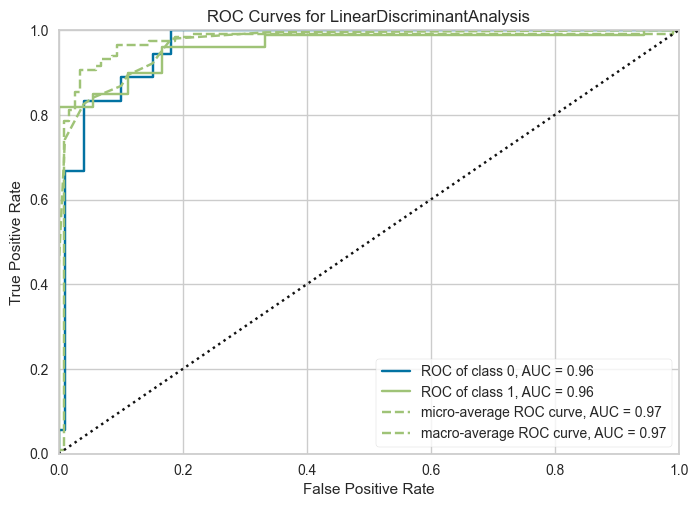

In [34]:
automl.plot_model(best_model)

It looks like our best model is **??**, closely followed by some others. This may change when you re-run this - there is some randomness built in that we are not fixing (e.g. for the cross-validation splits possibly), so the top model may be different each time this is run since the accuracy scores are so similar between models.

PyCaret can also plot a confusion matrix for us:

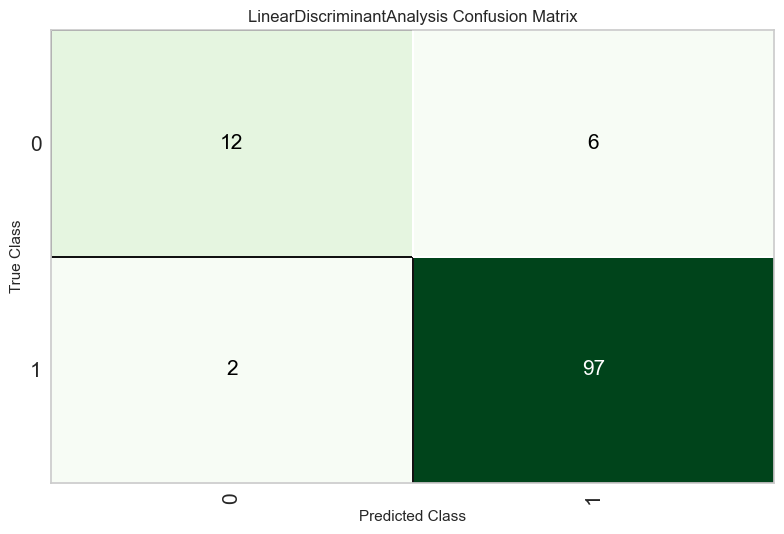

In [14]:
automl.plot_model(best_model, plot = 'confusion_matrix')

We can now make predictions. For example, we can make predictions on the last row:

In [15]:
df.iloc[-2:-1].shape

(1, 13)

We are selecting the last row, but using the indexing `[-2:-1]` to make it a 2D array instead of 1D (which throws an error). Try running `df.iloc[-1].shape` and `df.iloc[-2:-1].shape` to see how they differ.

We can use pycaret's predict_model function with the row above:

In [16]:
automl.predict_model(best_model, df.iloc[-2:-1])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,1.0000,0,1.0000,1.0000,1.0000,nan,0.0000


,Cholesterol,Glucose,HDL Chol,Age,Gender,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Diabetes,prediction_label,prediction_score
Patient number,,,,,,,,,,,,,,,
389,232,184,114,91,female,61,127,24.0,170,82,35,38,Diabetes,Diabetes,0.9176


We can see this creates a new column, 'Score', with the probability of class 1. It also creates a 'Label' column with the predicted label, where it rounds up if score is >= 0.5 (greater than or equal to 0.5).

We can also do predictions for the whole dataset:

In [17]:
predictions = automl.predict_model(best_model, data=df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.9308,0.9425,0.9308,0.9277,0.9272,0.7082,0.7153


In [18]:
predictions.head()

,Cholesterol,Glucose,HDL Chol,Age,Gender,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Diabetes,prediction_label,prediction_score
Patient number,,,,,,,,,,,,,,,
1,193,77,49,19,female,61,119,22.500000,118,70,32,38,No diabetes,No diabetes,0.9993
2,146,79,41,19,female,60,135,26.400000,108,58,33,40,No diabetes,No diabetes,0.9993
3,217,75,54,20,female,67,187,29.299999,110,72,40,45,No diabetes,No diabetes,0.9994
4,226,97,70,20,female,64,114,19.600000,122,64,31,39,No diabetes,No diabetes,0.9971
5,164,91,67,20,female,70,141,20.200001,122,86,32,39,No diabetes,No diabetes,0.9990


## Saving and loading our model

Next, we want to save our trained model so we can use it in a Python file later. pycaret has a handy function for this, which saves the model as a pickle file:

In [19]:
automl.save_model(best_model, 'pycaret_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Cholesterol', 'Glucose',
                                              'HDL Chol', 'Age', 'Height',
                                              'Weight', 'BMI', 'Systolic BP',
                                              'Diastolic BP', 'waist', 'hip'],
                                     transformer=SimpleImputer(add_indi...
 dtype: int64}],
                                                                return_df=True,
                                                                verbose=0))),
                 ('clean_column_names',
                  TransformerWrapper(exclude=None, include=None,
                     

You might be wondering "what the heck is a pickle file?" `pickle` is a built-in module in the Python standard library which allows for saving and loading of binary data. It's data that's been encoded (usually using hexidecimal encoding) to a file, and we can store any Python object as-is in a pickle file. Then we can load the data from the file and be right back where we left off. 

Once we have our saved pycaret model, we can test loading it and making predictions to make sure it works:

In [20]:
new_pycaret = ClassificationExperiment()
loaded_model = new_pycaret.load_model('pycaret_model')

Transformation Pipeline and Model Successfully Loaded


In [21]:
new_pycaret.predict_model(loaded_model, df.iloc[-2:-1])

,Cholesterol,Glucose,HDL Chol,Age,Gender,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Diabetes,prediction_label,prediction_score
Patient number,,,,,,,,,,,,,,,
389,232,184,114,91,female,61,127,24.0,170,82,35,38,Diabetes,Diabetes,0.9176


# Making a Python module to make predictions

We can now use this model in a Python file to take in new data and make a prediction. We will first need to compose a Python file. We can do this in many ways:

- Jupyter and Jupyter Lab
- VS Code
- Atom
- Notepad++
- Other text editors or IDEs (integrated development environments)

The benefit of using a code editor or IDE is that it will have lots of bells and whistles, like syntax highlighting, autocomplete, and many other things depending on the code editor or IDE. VS Code is one of the top-most used editors by data scientists and software developers, although you can try any IDE or code editor for Python that you like. You can easily install VS Code through Anaconda Navigator or by visiting the VS Code website. VS Code is developed by Microsoft, and there is also an IDE Visual Studio Code.

The file we've created is show below:

In [22]:
from IPython.display import Code

Code('predict_diabetes_pycaret.py')

predict_diabetes_pycaret.py

We can test out running the file with the Jupyter "magic" command %run:

In [23]:
%run pcaret_predict_diabetes.py

Transformation Pipeline and Model Successfully Loaded
predictions:
                Cholesterol  Glucose  HDL Chol  Age  Gender  Height  Weight  \
Patient number                                                                
391                     185      255       112   77       0      59     189   
392                     322       87        99   37       0      63     125   
393                     301      166       101   49       1      57     131   
394                     199       87        72   63       1      65     220   

                      BMI  Systolic BP  Diastolic BP  waist  hip  \
Patient number                                                     
391             38.200001          146            91     40   47   
392             22.100000          222            85     32   43   
393             28.299999          166            87     37   36   
394             36.599998          189            82     48   49   

                waist_hip_ratio  hdl_chol_ratio p

<Figure size 800x550 with 0 Axes>

We can run the above line over and over after making changes to the file while we are writing it. The true values are 1, 0, 1, 1, so our model is working OK but not perfect. We have 2 false positives in the new data. However, this new data was synthesized based on existing data, so it is a little random. The same goes for the new churn data for the assignment. 

# Saving our code to GitHub

The last few things to do are to write a short summary of our process and results and create a GitHub repository and upload our code there. If you don't already have an account, head over to github.com and create one. Then, you need to install a GitHub client on your computer. Definitely the easiest way is to use the [GUI](https://desktop.github.com/), although if you're more advanced or adventurous you can use the CLI instead.  GitHub is also run and owned by Microsoft (they bought it in 2018).

Once you have an account and GitHub installed, you can create a new repository, either through the GUI with File -> New repository or through the web interface. It's best to select the option 'Initialize this repository with a README' and 'Python' for the 'Git ignore' option. The Git ignore option creates a file that ignores common files that we don't need that are related to Python (like our Jupyter Notebook checkpoints folders). Lastly, it's not a bad idea to choose a license. The MIT license is a a very open and open-source license, although others are more restrictive like Apache. We can choose MIT here since we aren't worried about protecting intellectual property in this case.

When you publish to GitHub you need to include a README file that explains and defines the repo.  It is also good practice to include along with you codebase a `requirements.txt` file `pip freeze > requirements.txt` which will include all the packages used in the projects.


In [24]:
! pip freeze > requirements.txt

Once we've created the repository, we can open the folder by browsing there, with a hotkey through the GUI, or by clicking the button in the GUI to open the folder. We need to copy our work there, then write a short note in the 'summary' area, and hit 'commit to main'. The 'main' label is a branch of the Git repository - we can have several branches in parallel but 'main' is default. Then we can hit the 'push origin' button in the upper right to upload our data to the GitHub's cloud.  Last, we simply need to put the link in a text file and turn that in for our week 5 assignment (using the churn data instead of the diabetes data).

# Optional advanced section

Although we don't have walkthroughs for it this week, there are other autoML packages in Python that we can use. These have documentation with examples showing how to use them. For example, here are the docs for some of these:
- [H2O](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)
- [TPOT](http://epistasislab.github.io/tpot/using/)
- [MLBox](https://mlbox.readthedocs.io/en/latest/introduction.html)

Of course, using these packages requires that you first install them. At least with H2O, using conda is easier than with pip.

We can also improve our Python module by using a class instead of plain functions. We can read more about creating classes [here](https://realpython.com/python3-object-oriented-programming/). 

### Deactivate your venv

Remember to deactivate your venv at this point.